In [129]:
import sys
sys.path.append('..')
import numpy as np
from coolroutes import planning, visualization
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import pandas

## Read data

In [116]:
original = pd.read_pickle("../data/top_400_shade_data.pickle")
original = gpd.GeoDataFrame(original, geometry="geometry")

to_process = original[["geometry", "group_id", "traffic", "13_shade_block"]]
to_process = to_process.rename(columns={"13_shade_block":"shade"})
to_process.shade = to_process.shade.apply(lambda x: x.values)
to_process.traffic = to_process.traffic.apply(lambda x: x / max(to_process.traffic))
to_process.head()

,geometry,group_id,traffic,shade
0,"MULTILINESTRING ((724025.025 6175551.339, 7240...",2,0.484289,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"MULTILINESTRING ((723999.496 6174336.052, 7240...",6,0.513089,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"MULTILINESTRING ((723999.496 6174336.052, 7240...",8,0.358401,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"MULTILINESTRING ((724001.938 6174333.178, 7240...",11,0.313051,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"MULTILINESTRING ((724625.288 6174941.454, 7246...",13,0.447949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [32]:
parishes = gpd.read_file("../model/parishes.geojson")

In [169]:
BUDGET = 10000
A = 0.2
TREES_IN_ROW = 5
MIN_SHADE = 0.7
MIN_TRAFFIC = 0.2

## Whole area

C:\Users\anita\miniconda3\envs\shadow-routes\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Selected streets: 20


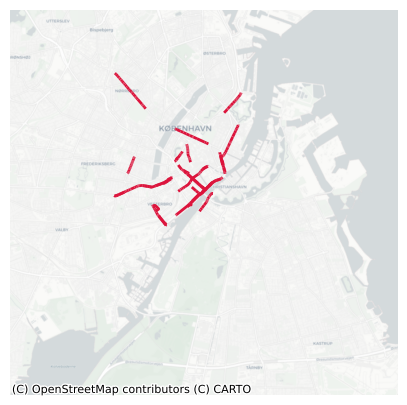

In [170]:
result = planning.naive_selection(to_process, 
                                  BUDGET, 
                                  a = A,
                                  trees_in_row = TREES_IN_ROW,
                                  min_shade = MIN_SHADE,
                                  min_traffic = MIN_TRAFFIC)
print(f"Selected streets: {len(result)}")

selected = original[original.group_id.isin(result.group_id)].to_crs(4326)

ax = selected.plot(figsize=(5, 5), linewidth=2, color="crimson")
ax.set_ylim([55.62141308805854, 55.715722643196166])
ax.set_xlim([12.494584296105629, 12.661448679631935])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
plt.axis('off')
ax.set_aspect('auto')

C:\Users\anita\miniconda3\envs\shadow-routes\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\anita\miniconda3\envs\shadow-routes\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\anita\miniconda3\envs\shadow-routes\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Selected streets: 74


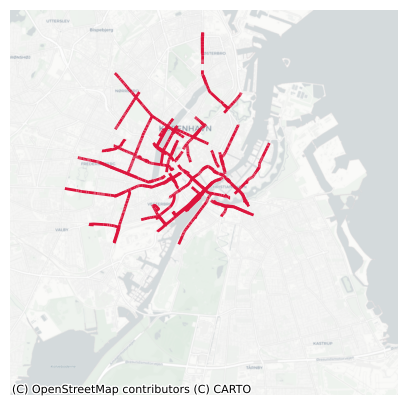

In [171]:
constituencies = gpd.read_file("../model/constituencies.geojson")
constituencies = constituencies.to_crs(epsg=3857)
constituencies["budget"] = constituencies.area.apply(lambda x: BUDGET * (x / sum(grid.area)))

results = []
for i in range(len(constituencies)):
    tile = constituencies.iloc[i]
    tile = gpd.GeoDataFrame(geometry = [tile.geometry], crs=3857)
    result = planning.naive_selection(to_process.to_crs(3857).overlay(tile), 
                                  BUDGET, 
                                  a = A,
                                  trees_in_row = TREES_IN_ROW,
                                  min_shade = MIN_SHADE,
                                  min_traffic = MIN_TRAFFIC)
    results.append(result) if not result.empty else None
    
results = pd.concat(results)
print(f"Selected streets: {len(results)}")


selected = original[original.group_id.isin(results.group_id)].to_crs(4326)

ax = selected.plot(figsize=(5, 5), linewidth=2, color="crimson")
ax.set_ylim([55.62141308805854, 55.715722643196166])
ax.set_xlim([12.494584296105629, 12.661448679631935])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
plt.axis('off')
ax.set_aspect('auto')

In [ ]:
# data_sources = [
#     selected, "Bicycle network"),
# ]

# vis = visualization.Vis()
# vis.save_to_html(data_sources)
# vis.display()